In [2]:
import mindspore
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor, ms_function
import matplotlib.pyplot as plt
from layers import Dense, Embedding, Conv1d
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

In [3]:
def make_batch(sentences, src_vocab, tgt_vocab):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return Tensor(input_batch, mindspore.int32), Tensor(output_batch, mindspore.int32), Tensor(target_batch, mindspore.int32)

In [4]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return Tensor(sinusoid_table, mindspore.float32)

In [5]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.shape
    batch_size, len_k = seq_k.shape
    
    pad_attn_mask = ops.equal(seq_k, 0)
    pad_attn_mask = pad_attn_mask.expand_dims(1) # batch_size x 1 x len_k(=len_q), one is masking

    return ops.BroadcastTo((batch_size, len_q, len_k))(pad_attn_mask) # batch_size x len_q x len_k

In [6]:
def get_attn_subsequent_mask(subsequent_mask):
    subsequent_mask = subsequent_mask.expand_dims(0)
    return subsequent_mask

In [7]:
class ScaledDotProductAttention(nn.Cell):
    def __init__(self, d_k):
        super().__init__()
        self.scale = Tensor(d_k, mindspore.float32)
        self.softmax = nn.Softmax(axis=-1)
        
    def construct(self, Q, K, V, attn_mask):
        K = K.transpose((0, 1, 3, 2))
        scores = ops.matmul(Q, K) / ops.sqrt(self.scale) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores = scores.masked_fill(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = self.softmax(scores)
        context = ops.matmul(attn, V)
        return context, attn

In [8]:
class MultiHeadAttention(nn.Cell):
    def __init__(self, d_model, d_k, n_heads):
        super().__init__()
        self.d_k = d_k
        self.n_heads = n_heads
        self.W_Q = Dense(d_model, d_k * n_heads)
        self.W_K = Dense(d_model, d_k * n_heads)
        self.W_V = Dense(d_model, d_k * n_heads)
        self.linear = Dense(n_heads * d_k, d_model)
        self.layer_norm = nn.LayerNorm((d_model, ), epsilon=1e-5)
        self.attention = ScaledDotProductAttention(d_k)
        
    def construct(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.shape[0]
        q_s = self.W_Q(Q).view((batch_size, -1, self.n_heads, self.d_k)) 
        k_s = self.W_K(K).view((batch_size, -1, self.n_heads, self.d_k)) 
        v_s = self.W_V(V).view((batch_size, -1, self.n_heads, self.d_k)) 
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = q_s.transpose((0, 2, 1, 3)) # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = k_s.transpose((0, 2, 1, 3)) # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = v_s.transpose((0, 2, 1, 3)) # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.expand_dims(1)
        attn_mask = ops.tile(attn_mask, (1, self.n_heads, 1, 1)) # attn_mask : [batch_size x n_heads x len_q x len_k]
        
        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = self.attention(q_s, k_s, v_s, attn_mask)
        context = context.transpose((0, 2, 1, 3)).view((batch_size, -1, self.n_heads * self.d_k)) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context) 
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

In [9]:
class PoswiseFeedForward(nn.Cell):
    def __init__(self, d_ff, d_model):
        super().__init__()
        self.conv1 = Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm((d_model, ), epsilon=1e-5)
        self.relu = nn.ReLU()
        
    def construct(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = inputs.transpose((0, 2, 1))
        output = self.conv1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = output.transpose((0, 2, 1))
        return self.layer_norm(output + residual)

In [10]:
class EncoderLayer(nn.Cell):
    def __init__(self, d_model, d_k, n_heads, d_ff):
        super().__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, d_k, n_heads)
        self.pos_ffn = PoswiseFeedForward(d_ff, d_model)
        
    def construct(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [11]:
class DecoderLayer(nn.Cell):
    def __init__(self, d_model, d_k, n_heads, d_ff):
        super().__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, d_k, n_heads)
        self.dec_enc_attn = MultiHeadAttention(d_model, d_k, n_heads)
        self.pos_ffn = PoswiseFeedForward(d_ff, d_model)
        
    def construct(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

In [12]:
class Encoder(nn.Cell):
    def __init__(self, src_vocab_size, d_model, d_k, n_heads, d_ff, n_layers, src_len):
        super().__init__()
        self.src_emb = Embedding(src_vocab_size, d_model)
        self.pos_emb = Embedding.from_pretrained_embedding(get_sinusoid_encoding_table(src_len+1, d_model), freeze=True)
        self.layers = nn.CellList([EncoderLayer(d_model, d_k, n_heads, d_ff) for _ in range(n_layers)])
        # temp positional indexes
        self.pos = Tensor([[1, 2, 3, 4, 0]])
        
    def construct(self, enc_inputs):
        # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(self.pos)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [13]:
class Decoder(nn.Cell):
    def __init__(self, tgt_vocab_size, d_model, d_k, n_heads, d_ff, n_layers, tgt_len):
        super().__init__()
        self.tgt_emb = Embedding(tgt_vocab_size, d_model)
        self.pos_emb = Embedding.from_pretrained_embedding(get_sinusoid_encoding_table(tgt_len+1, d_model), freeze=True)
        self.layers = nn.CellList([DecoderLayer(d_model, d_k, n_heads, d_ff) for _ in range(n_layers)])
        
        # temp positional indexes
        self.pos = Tensor([[5, 1, 2, 3, 4]])
        
        ones = np.ones(shape=(tgt_len, tgt_len))
        self.subsequent_mask = Tensor(np.triu(ones, k=1), dtype=mindspore.float32)
        
    def construct(self, dec_inputs, enc_inputs, enc_outputs):
        # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(self.pos)
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(self.subsequent_mask)
        dec_self_attn_mask = ops.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [14]:
class Transformer(nn.Cell):
    def __init__(self, d_model, d_k, n_heads, d_ff, n_layers, src_vocab_size, tgt_vocab_size, src_len, tgt_len):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, d_k, n_heads, d_ff, n_layers, src_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, d_k, n_heads, d_ff, n_layers, tgt_len)
        self.projection = Dense(d_model, tgt_vocab_size, has_bias=False)

    def construct(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view((-1, dec_logits.shape[-1])), enc_self_attns, dec_self_attns, dec_enc_attns

In [15]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# Transformer Parameters
# Padding Should be Zero
src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 6 # length of source
tgt_len = 5 # length of target

d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k  = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

In [16]:
model = Transformer(d_model, d_k, n_heads, d_ff, n_layers, src_vocab_size, tgt_vocab_size, src_len, tgt_len)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.0001)
# print(model.trainable_params())
enc_inputs, dec_inputs, target_batch = make_batch(sentences, src_vocab, tgt_vocab)

In [18]:
def forward(enc_inputs, dec_inputs, target_batch):
    outputs, _, _, _, = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch)

    return loss

In [19]:
grad_fn = ops.value_and_grad(forward, None, optimizer.parameters)

In [20]:
@ms_function
def train_step(enc_inputs, dec_inputs, target_batch):
    loss, grads = grad_fn(enc_inputs, dec_inputs, target_batch)
    optimizer(grads)
    return loss

In [21]:
model.set_train()

# Training
for epoch in range(20):
    # hidden : [num_layers * num_directions, batch, hidden_size]
    loss = train_step(enc_inputs, dec_inputs, target_batch.view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss.asnumpy()))

Epoch: 0001 cost = 2.596976
Epoch: 0002 cost = 1.083525
Epoch: 0003 cost = 0.804770
Epoch: 0004 cost = 0.334796
Epoch: 0005 cost = 0.180342
Epoch: 0006 cost = 0.042456
Epoch: 0007 cost = 0.009277
Epoch: 0008 cost = 0.003621
Epoch: 0009 cost = 0.002399
Epoch: 0010 cost = 0.002193
Epoch: 0011 cost = 0.002270
Epoch: 0012 cost = 0.002314
Epoch: 0013 cost = 0.002193
Epoch: 0014 cost = 0.001918
Epoch: 0015 cost = 0.001599
Epoch: 0016 cost = 0.001310
Epoch: 0017 cost = 0.001075
Epoch: 0018 cost = 0.000890
Epoch: 0019 cost = 0.000741
Epoch: 0020 cost = 0.000619


In [22]:
# Test
predict, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
predict = predict.asnumpy().argmax(1)
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])


ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


In [23]:
def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.asnumpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

first head of last state enc_self_attns


/home/lvyufeng/miniconda3/envs/ms1.9/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/home/lvyufeng/miniconda3/envs/ms1.9/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


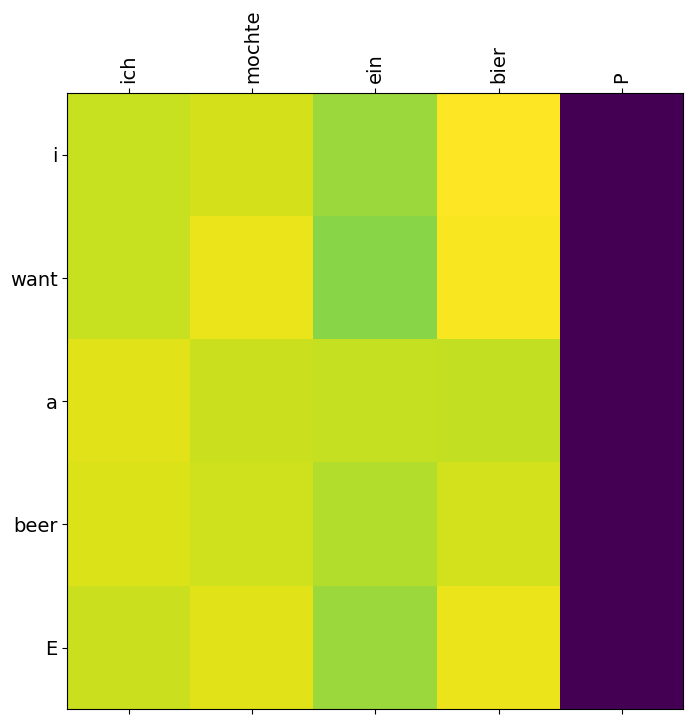

first head of last state dec_self_attns


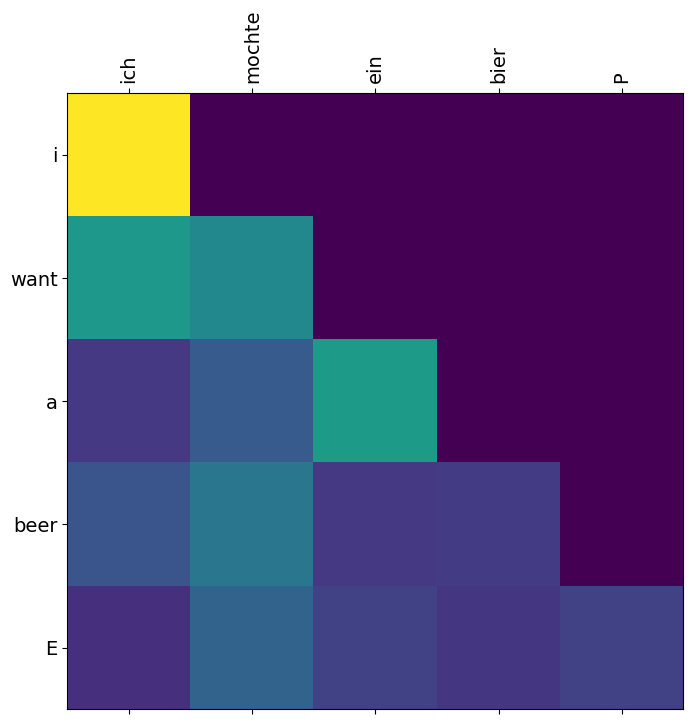

first head of last state dec_enc_attns


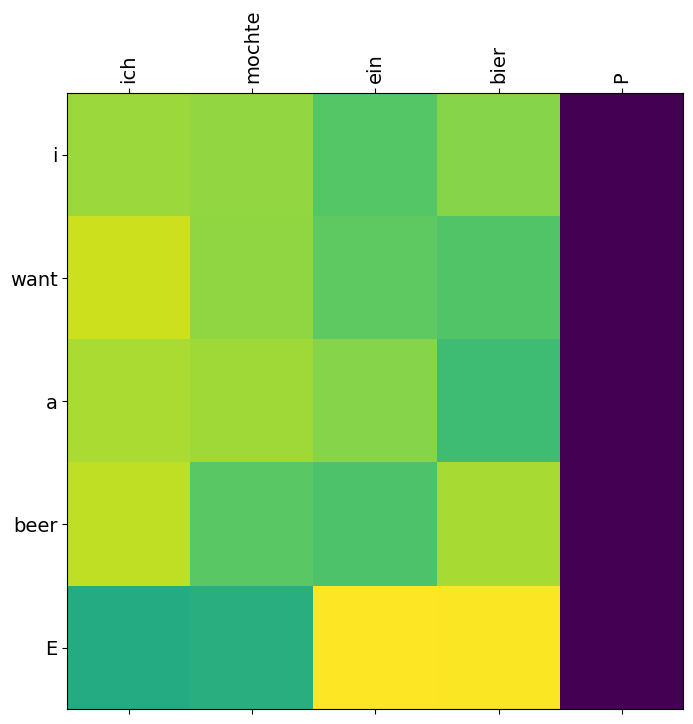

In [24]:
print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)